In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools
import datetime
from datetime import date
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [4]:
df_application=pd.read_csv(r"C:\Users\ngaih\OneDrive\Desktop\Xccelarate Course Material\Assignment\Machine Learning Project\Data source\HenryChan application_record.csv", encoding = 'utf-8')
df_credit=pd.read_csv(r"C:\Users\ngaih\OneDrive\Desktop\Xccelarate Course Material\Assignment\Machine Learning Project\Data source\Henru Chan credit_record.csv", encoding = 'utf-8')

In [5]:
#Feature Engineering, grading each client's credit 

In [6]:
#When did the client open the account (The negative number means how many months before today(20230412)

AC_Open_Month=pd.DataFrame(df_credit.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
AC_Open_Month=AC_Open_Month.rename(columns={'MONTHS_BALANCE':'AC_Open_Months_Ago'})

#Merging AC_Open_Months_Ago into df_application

new_df_application=df_application.merge(AC_Open_Month, how = 'left', on ='ID')
print(new_df_application)

             ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0       5008804           M            Y               Y             0   
1       5008805           M            Y               Y             0   
2       5008806           M            Y               Y             0   
3       5008808           F            N               Y             0   
4       5008809           F            N               Y             0   
...         ...         ...          ...             ...           ...   
438552  6840104           M            N               Y             0   
438553  6840222           F            N               N             0   
438554  6841878           F            N               N             0   
438555  6842765           F            N               Y             0   
438556  6842885           F            N               Y             0   

        AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0               427500.0      

In [7]:
#Defining good credit record and bad credit record which are makred as 1 and 0 respectively.
# 0=good=overdue less than or equal 60 days
# 1=bad=overdue more than 60 days

In [8]:
df_credit['Grade'] = None
df_credit['Grade'][df_credit['STATUS']=='2']='Bad'
df_credit['Grade'][df_credit['STATUS']=='3']='Bad'
df_credit['Grade'][df_credit['STATUS']=='4']='Bad'
df_credit['Grade'][df_credit['STATUS']=='5']='Bad'

In [9]:
grading=df_credit.groupby('ID').count()
grading['Grade'][grading['Grade']>0]='Bad'
grading['Grade'][grading['Grade']==0]='Good'
grading=grading[['Grade']]
new_df_application=pd.merge(new_df_application, grading, how='inner', on='ID')
new_df_application['target']=new_df_application['Grade']
new_df_application.loc[new_df_application['target']=='Bad', 'target']=1
new_df_application.loc[new_df_application['target']=='Good', 'target']=0

In [10]:
print(grading['Grade'].value_counts())
grading['Grade'].value_counts(normalize=True)

Good    45318
Bad       667
Name: Grade, dtype: int64


Good    0.985495
Bad     0.014505
Name: Grade, dtype: float64

In [11]:
#Renaming the column name of each feature

In [12]:
new_df_application.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car_Possession','FLAG_OWN_REALTY':'Property posession',
                         'CNT_CHILDREN':'How many children','AMT_INCOME_TOTAL':'Annual Income',
                         'NAME_EDUCATION_TYPE':'Education Level','NAME_FAMILY_STATUS':'Marital Status',
                        'NAME_HOUSING_TYPE':'Housing Type','FLAG_EMAIL':'Email',
                         'NAME_INCOME_TYPE':'Types of Income','FLAG_WORK_PHONE':'Work Phone Posession',
                         'FLAG_PHONE':'Personal Mobile Phone Posession','CNT_FAM_MEMBERS':'Family Size',
                        'OCCUPATION_TYPE':'Occupation'
                        },inplace=True)

In [13]:
new_df_application.dropna()
new_df_application = new_df_application.mask(new_df_application == 'NULL').dropna()

In [14]:
feature_names_df=pd.DataFrame(new_df_application.columns, columns=['Features'])
feature_names_df['IV']=None
feature_to_drop=['FLAG_MOBIL', 'AC_Open_Months_Ago', 'Grade', 'target', 'ID' ]

for i in feature_to_drop:
    feature_names_df.drop(feature_names_df[feature_names_df['Features']==i].index, inplace=True)

In [15]:
#Defining functions for calculating Weight of evidence (WOE) and information value (IV)

In [16]:
def calc_iv (df, feature, target, pr=False):
    lst=[]
    df[feature]=df[feature].fillna('NULL')
    
    for i in range(df[feature].nunique()):
        val=list(df[feature].unique())[i]
        lst.append([feature, val, 
                    df[df[feature]==val].count()[feature],
                    df[(df[feature]==val) & (df[target]==0)].count()[feature],
                    df[(df[feature]==val) & (df[target]==1)].count()[feature]])
        
    data=pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All']-data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WOE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data= data.replace({'WOE':{np.inf:0, -np.inf: 0}})
    
    data['IV']=data['WOE'] * (data['Distribution Good'] - data['Distribution Bad'])
    
    data= data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range (len(data.index))
    
    if pr:
        print(data)
        print('IV = ' ,data['IV'].sum())
        
    iv = data['IV'].sum()
    print('This varible\'s IV is :' , iv)
    print(df[feature].value_counts())
    return iv, data

In [17]:
def convert_dummy(df, feature, rank=0):
    pos= pd.get_dummies(df[feature], prefix=feature)
    mode= df[feature].value_counts().index[rank]
    biggest= feature + '_' + str(mode)
    pos.drop([biggest], axis=1, inplace=True)
    df.drop([feature], axis=1, inplace=True)
    df=df.join(pos)
    return df

In [18]:
def get_category (df, col, binsnum, labels, qcut= False):
    
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels)
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels)
    
    localdf = pd.DataFrame(localdf)
    name='Classified' + '_' + col
    localdf[name] = localdf [col]
    df=df.join(localdf[name])
    df[name]=df[name].astype(object)
    return df

In [19]:
# WOE and IV of Gender

In [20]:
new_df_application['Gender']=new_df_application['Gender'].replace(['F','M'],[0,1])
print(new_df_application['Gender'].value_counts())
iv, data = calc_iv(new_df_application, 'Gender', 'target')
feature_names_df.loc[feature_names_df['Features']=='Gender', 'IV'] = iv
data.head()

0    15630
1     9504
Name: Gender, dtype: int64
This varible's IV is : 0.02520350452745081
0    15630
1     9504
Name: Gender, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,Gender,0,15630,15400,230,0.621867,0.014715,0.623179,0.545024,0.134005,0.010473
1,Gender,1,9504,9312,192,0.378133,0.020202,0.376821,0.454976,-0.188475,0.014730


In [21]:
# WOE and IV of Car Posession

In [22]:
new_df_application['Car_Possession']=new_df_application['Car_Possession'].replace(['N','Y'],[0,1])
print(new_df_application['Car_Possession'].value_counts())
iv, data = calc_iv(new_df_application, 'Car_Possession', 'target')
feature_names_df.loc[feature_names_df['Features']=='Car_Possession', 'IV'] = iv
data.head()

0    14618
1    10516
Name: Car_Possession, dtype: int64
This varible's IV is : 4.54248124999671e-06
0    14618
1    10516
Name: Car_Possession, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,Car_Possession,0,14618,14373,245,0.581603,0.016760,0.58162,0.580569,0.00181,0.000002
1,Car_Possession,1,10516,10339,177,0.418397,0.016831,0.41838,0.419431,-0.00251,0.000003


In [23]:
# WOE and IV of House Posession

In [24]:
new_df_application['Property posession']=new_df_application['Property posession'].replace(['N','Y'],[0,1])
print(new_df_application['Property posession'].value_counts())
iv, data = calc_iv(new_df_application, 'Property posession', 'target')
feature_names_df.loc[feature_names_df['Features']=='Property posession', 'IV'] = iv
data.head()

1    16461
0     8673
Name: Property posession, dtype: int64
This varible's IV is : 0.02744070350168343
1    16461
0     8673
Name: Property posession, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,Property posession,0,8673,8494,179,0.34507,0.020639,0.34372,0.424171,-0.210309,0.016920
1,Property posession,1,16461,16218,243,0.65493,0.014762,0.65628,0.575829,0.130777,0.010521


In [25]:
# WOE and IV of Personal Phone Posession

In [26]:
new_df_application['Personal Mobile Phone Posession']=new_df_application['Personal Mobile Phone Posession'].astype(str)
print(new_df_application['Personal Mobile Phone Posession'].value_counts(normalize=True, sort=False))
new_df_application.drop(new_df_application[new_df_application['Personal Mobile Phone Posession']=='nan'].index, inplace=True)
iv, data =calc_iv(new_df_application, 'Personal Mobile Phone Posession', 'target')
feature_names_df.loc[feature_names_df['Features']=='Personal Mobile Phone Posession','IV'] =iv
data.head()

0    0.707209
1    0.292791
Name: Personal Mobile Phone Posession, dtype: float64
This varible's IV is : 0.0005480495762639297
0    17775
1     7359
Name: Personal Mobile Phone Posession, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,Personal Mobile Phone Posession,0,17775,17481,294,0.707209,0.016540,0.707389,0.696682,0.015251,0.000163
1,Personal Mobile Phone Posession,1,7359,7231,128,0.292791,0.017394,0.292611,0.303318,-0.035937,0.000385


In [27]:
# WOE and IV of having an email

In [28]:
print(new_df_application['Email'].value_counts(normalize=True, sort=False))
new_df_application['Email']=new_df_application['Email'].astype(str)
iv, data = calc_iv(new_df_application, 'Email', 'target' )
feature_names_df.loc[feature_names_df['Features']=='Email','IV']=iv
data.head(5)

0    0.89934
1    0.10066
Name: Email, dtype: float64
This varible's IV is : 1.7343581493999816e-05
0    22604
1     2530
Name: Email, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,Email,0,22604,22225,379,0.89934,0.016767,0.899361,0.898104,0.001398,0.000002
1,Email,1,2530,2487,43,0.10066,0.016996,0.100639,0.101896,-0.012407,0.000016


In [29]:
# WOE and IV of Work Phone Posession

In [30]:
new_df_application['Work Phone Posession']=new_df_application['Work Phone Posession'].astype(int)
iv, data = calc_iv(new_df_application, 'Work Phone Posession', 'target' )
new_df_application.drop(new_df_application[new_df_application['Work Phone Posession']=='nan'].index, inplace=True)
feature_names_df.loc[feature_names_df['Features']=='Work Phone Posession','IV']=iv
data.head(5)

This varible's IV is : 0.002042429795148461
0    18252
1     6882
Name: Work Phone Posession, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,Work Phone Posession,0,18252,17954,298,0.726188,0.016327,0.72653,0.706161,0.028436,0.000579
1,Work Phone Posession,1,6882,6758,124,0.273812,0.018018,0.27347,0.293839,-0.071838,0.001463


In [31]:
# Condinuous Variable, here I will first use pd.qcut to categorize the data, then use pd.get_dummy function as defined above 
# as there are more than 2 different types of values in the feature after categorization

In [32]:
# WOE and IV of Number of Children

In [33]:
new_df_application.loc[new_df_application['How many children'] >= 2,'How many children']='2More'
print(new_df_application['How many children'].value_counts(sort=False))

0        15908
2More     3108
1         6118
Name: How many children, dtype: int64


In [34]:
iv, data=calc_iv(new_df_application,'How many children','target')
feature_names_df.loc[feature_names_df['Features']=='How many children','IV']=iv
data.head()

This varible's IV is : 0.0011214542503301935
0        15908
1         6118
2More     3108
Name: How many children, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,How many children,0,15908,15635,273,0.632928,0.017161,0.632689,0.646919,-0.022243,0.000317
1,How many children,1,6118,6021,97,0.243415,0.015855,0.243647,0.229858,0.058259,0.000803
2,How many children,2More,3108,3056,52,0.123657,0.016731,0.123665,0.123223,0.003580,0.000002


In [35]:
new_df_application = convert_dummy(new_df_application,'How many children')

In [36]:
# WOE and IV of Annual Income

(2.544, 18.18]      14663
(18.18, 33.66]       8464
(33.66, 49.14]       1637
(49.14, 64.62]        175
(64.62, 80.1]         124
(80.1, 95.58]          50
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: Annual Income, dtype: int64


<AxesSubplot:ylabel='Frequency'>

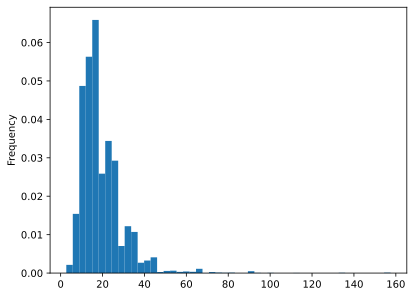

In [37]:
new_df_application['Annual Income']=new_df_application['Annual Income'].astype(int)
new_df_application['Annual Income'] = new_df_application['Annual Income']/10000 
print(new_df_application['Annual Income'].value_counts(bins=10,sort=False))
new_df_application['Annual Income'].plot(kind='hist',bins=50,density=True)

In [38]:
new_df_application = get_category(new_df_application,'Annual Income', 3, ["low","medium", "high"], qcut=True)
iv, data = calc_iv(new_df_application,'Classified_Annual Income','target')
feature_names_df.loc[feature_names_df['Features']=='Annual Income','IV']=iv
data.head()

This varible's IV is : 0.0024219962221596752
low       8996
high      8244
medium    7894
Name: Classified_Annual Income, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,Classified_Annual Income,high,8244,8096,148,0.328002,0.017952,0.327614,0.350711,-0.068126,0.001573
1,Classified_Annual Income,low,8996,8849,147,0.357922,0.016341,0.358085,0.348341,0.027588,0.000269
2,Classified_Annual Income,medium,7894,7767,127,0.314077,0.016088,0.314301,0.300948,0.043413,0.000580


In [39]:
new_df_application = convert_dummy(new_df_application,'Classified_Annual Income')

In [40]:
# WOE and IV of Age

(19.951999999999998, 24.7]    0.025066
(24.7, 29.4]                  0.134280
(29.4, 34.1]                  0.169770
(34.1, 38.8]                  0.140805
(38.8, 43.5]                  0.173072
(43.5, 48.2]                  0.141880
(48.2, 52.9]                  0.099069
(52.9, 57.6]                  0.076550
(57.6, 62.3]                  0.032585
(62.3, 67.0]                  0.006923
Name: Age, dtype: float64


<AxesSubplot:ylabel='Frequency'>

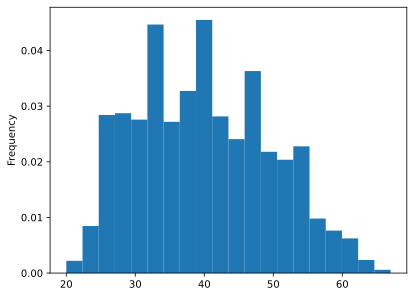

In [41]:
new_df_application['Age']=-(new_df_application['DAYS_BIRTH'])//365
print(new_df_application['Age'].value_counts(bins=10,normalize=True,sort=False))
new_df_application['Age'].plot(kind='hist',bins=20,density=True)

In [42]:
new_df_application = get_category(new_df_application,'Age',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(new_df_application,'Classified_Age','target')
feature_names_df.loc[feature_names_df['Features']=='DAYS_BIRTH','IV'] = iv
data.head()

This varible's IV is : 0.06593513858884348
medium     7916
low        7806
high       4414
lowest     4005
highest     993
Name: Classified_Age, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,Classified_Age,high,4414,4323,91,0.175619,0.020616,0.174935,0.215640,-0.209194,0.008515
1,Classified_Age,highest,993,989,4,0.039508,0.004028,0.040021,0.009479,1.440361,0.043992
2,Classified_Age,low,7806,7686,120,0.310575,0.015373,0.311023,0.284360,0.089625,0.002390
3,Classified_Age,lowest,4005,3921,84,0.159346,0.020974,0.158668,0.199052,-0.226754,0.009157
4,Classified_Age,medium,7916,7793,123,0.314952,0.015538,0.315353,0.291469,0.078758,0.001881


In [43]:
new_df_application = convert_dummy(new_df_application,'Classified_Age')

In [44]:
# WOE and IV of Working Years

<AxesSubplot:ylabel='Frequency'>

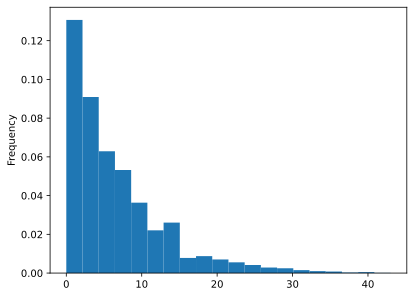

In [45]:
new_df_application['Work_Years']=-(new_df_application['DAYS_EMPLOYED'])//365
new_df_application[new_df_application['Work_Years']<0]=np.nan
new_df_application['Work_Years'].fillna(new_df_application['Work_Years'].mean(), inplace=True)
new_df_application['Work_Years'].plot(kind='hist', bins=20, density=True)

In [46]:
new_df_application=get_category(new_df_application, 'Work_Years', 5, ['lowest', 'low','medium','high','highest'])
iv, data= calc_iv(new_df_application, 'Classified_Work_Years', 'target')
feature_names_df.loc[feature_names_df['Features']=='DAYS_EMPLOYED', 'IV']=iv
data.head()

This varible's IV is : 0.04022152230816303
lowest     18254
low         4987
medium      1378
high         425
highest       90
Name: Classified_Work_Years, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,Classified_Work_Years,high,425,423,2,0.016909,0.004706,0.017117,0.004739,1.284186,0.015895
1,Classified_Work_Years,highest,90,90,0,0.003581,0.000000,0.003642,0.000000,0.000000,0.000000
2,Classified_Work_Years,low,4987,4921,66,0.198416,0.013234,0.199134,0.156398,0.241573,0.010324
3,Classified_Work_Years,lowest,18254,17916,338,0.726267,0.018516,0.724992,0.800948,-0.099635,0.007568
4,Classified_Work_Years,medium,1378,1362,16,0.054826,0.011611,0.055115,0.037915,0.374082,0.006434


In [47]:
new_df_application = convert_dummy(new_df_application,'Classified_Work_Years')

In [48]:
# WOE and IV of Family Size

In [49]:
new_df_application['Family Size'].value_counts(sort=False)

2.0     12697
1.0      4263
5.0       307
3.0      5216
4.0      2576
6.0        51
15.0        3
7.0        18
20.0        1
9.0         2
Name: Family Size, dtype: int64

In [50]:
new_df_application['Family Size']=new_df_application['Family Size'].astype(int)
new_df_application['Classified_famsize']=new_df_application['Family Size']
new_df_application['Classified_famsize']=new_df_application['Classified_famsize'].astype(object)
new_df_application.loc[new_df_application['Classified_famsize']>=3, 'Classified_famsize']='3more'
iv, data = calc_iv(new_df_application, 'Classified_famsize', 'target')
feature_names_df.loc[feature_names_df['Features']=='Family Size', 'IV']=iv
data.head()

This varible's IV is : 0.006156138510778323
2        12697
3more     8174
1         4263
Name: Classified_famsize, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,Classified_famsize,1,4263,4179,84,0.169611,0.019704,0.169108,0.199052,-0.163028,0.004882
1,Classified_famsize,2,12697,12489,208,0.505172,0.016382,0.505382,0.492891,0.025027,0.000313
2,Classified_famsize,3more,8174,8044,130,0.325217,0.015904,0.325510,0.308057,0.055108,0.000962


In [51]:
new_df_application = convert_dummy(new_df_application,'Classified_famsize')

In [52]:
# WOE and IV of Income Type

In [53]:
print(new_df_application['Types of Income'].value_counts(sort=False))
print(new_df_application['Types of Income'].value_counts(normalize=True, sort=False))
new_df_application.loc[new_df_application['Types of Income']=='Pensioner', 'Types of Income']='State servant'
new_df_application.loc[new_df_application['Types of Income']=='Student','Types of Income']='State servant'
iv, data =calc_iv(new_df_application,'Types of Income', 'target')
feature_names_df.loc[feature_names_df['Features']=='Types of Income', 'IV']=iv
data.head()
new_df_application=convert_dummy(new_df_application,'Types of Income')

Working                 15622
Commercial associate     7052
State servant            2437
Student                    10
Pensioner                  13
Name: Types of Income, dtype: int64
Working                 0.621549
Commercial associate    0.280576
State servant           0.096960
Student                 0.000398
Pensioner               0.000517
Name: Types of Income, dtype: float64
This varible's IV is : 5.159303327851404e-05
Working                 15622
Commercial associate     7052
State servant            2460
Name: Types of Income, dtype: int64


In [54]:
# WOE and IV of Occupation Type

In [55]:
new_df_application.loc[(new_df_application['Occupation']=='Cleaning staff') | (new_df_application['Occupation']=='Cooking staff') | (new_df_application['Occupation']=='Drivers') | (new_df_application['Occupation']=='Laborers') | (new_df_application['Occupation']=='Low-skill Laborers') | (new_df_application['Occupation']=='Security staff') | (new_df_application['Occupation']=='Waiters/barmen staff'),'Occupation']='Laborwk'
new_df_application.loc[(new_df_application['Occupation']=='Accountants') | (new_df_application['Occupation']=='Core staff') | (new_df_application['Occupation']=='HR staff') | (new_df_application['Occupation']=='Medicine staff') | (new_df_application['Occupation']=='Private service staff') | (new_df_application['Occupation']=='Realty agents') | (new_df_application['Occupation']=='Sales staff') | (new_df_application['Occupation']=='Secretaries'),'Occupation']='officewk'
new_df_application.loc[(new_df_application['Occupation']=='Managers') | (new_df_application['Occupation']=='High skill tech staff') | (new_df_application['Occupation']=='IT staff'),'Occupation']='hightecwk'
print(new_df_application['Occupation'].value_counts())
iv, data=calc_iv(new_df_application,'Occupation','target')
feature_names_df.loc[feature_names_df['Features']=='Occupation','IV']=iv
data.head()

Laborwk      10496
officewk     10183
hightecwk     4455
Name: Occupation, dtype: int64
This varible's IV is : 0.004820472062853304
Laborwk      10496
officewk     10183
hightecwk     4455
Name: Occupation, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,Occupation,Laborwk,10496,10311,185,0.417602,0.017626,0.417247,0.438389,-0.049428,0.001045
1,Occupation,hightecwk,4455,4375,80,0.177250,0.017957,0.177039,0.189573,-0.068404,0.000857
2,Occupation,officewk,10183,10026,157,0.405148,0.015418,0.405714,0.372038,0.086652,0.002918


In [56]:
new_df_application = convert_dummy(new_df_application,'Occupation')

In [57]:
# WOE and IV of House Type

In [58]:
iv, data = calc_iv(new_df_application,'Housing Type', 'target')
feature_names_df.loc[feature_names_df['Features']=='Housing Type', 'IV']=iv
data.head()

This varible's IV is : 0.0073275026880227365
House / apartment      22102
With parents            1430
Municipal apartment      812
Rented apartment         439
Office apartment         199
Co-op apartment          152
Name: Housing Type, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,Housing Type,Co-op apartment,152,149,3,0.006048,0.019737,0.006029,0.007109,-0.164705,0.000178
1,Housing Type,House / apartment,22102,21738,364,0.879367,0.016469,0.879654,0.862559,0.019624,0.000335
2,Housing Type,Municipal apartment,812,793,19,0.032307,0.023399,0.032090,0.045024,-0.338655,0.004380
3,Housing Type,Office apartment,199,194,5,0.007918,0.025126,0.007850,0.011848,-0.411619,0.001646
4,Housing Type,Rented apartment,439,433,6,0.017466,0.013667,0.017522,0.014218,0.208939,0.000690


In [59]:
new_df_application=convert_dummy(new_df_application,'Housing Type')

In [60]:
# WOE and IV of Education Level

In [61]:
new_df_application.loc[new_df_application['Education Level']=='Academic degree','Education Level']='Higher education'
iv, data=calc_iv(new_df_application,'Education Level','target')
feature_names_df.loc[feature_names_df['Features']=='Education Level','IV']=iv
data.head()

This varible's IV is : 0.010361794017679489
Secondary / secondary special    16808
Higher education                  7146
Incomplete higher                  993
Lower secondary                    187
Name: Education Level, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,Education Level,Higher education,7146,7018,128,0.284316,0.017912,0.283992,0.303318,-0.065836,0.001272
1,Education Level,Incomplete higher,993,972,21,0.039508,0.021148,0.039333,0.049763,-0.235206,0.002453
2,Education Level,Lower secondary,187,181,6,0.007440,0.032086,0.007324,0.014218,-0.663301,0.004573
3,Education Level,Secondary / secondary special,16808,16541,267,0.668736,0.015885,0.669351,0.632701,0.056310,0.002064


In [62]:
new_df_application=convert_dummy(new_df_application,'Education Level')

In [63]:
# WOE and IV of Marriage Condition

In [64]:
new_df_application['Marital Status'].value_counts(normalize=True,sort=False)
iv, data=calc_iv(new_df_application,'Marital Status','target')
feature_names_df.loc[feature_names_df['Features']=='Marital Status','IV']=iv
data.head()

This varible's IV is : 0.043137115423127946
Married                 17509
Single / not married     3445
Civil marriage           2133
Separated                1467
Widow                     580
Name: Marital Status, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,Marital Status,Civil marriage,2133,2101,32,0.084865,0.015002,0.085019,0.075829,0.114394,0.001051
1,Marital Status,Married,17509,17232,277,0.696626,0.015820,0.697313,0.656398,0.060467,0.002474
2,Marital Status,Separated,1467,1452,15,0.058367,0.010225,0.058757,0.035545,0.502608,0.011666
3,Marital Status,Single / not married,3445,3362,83,0.137065,0.024093,0.136047,0.196682,-0.368588,0.022349
4,Marital Status,Widow,580,565,15,0.023076,0.025862,0.022863,0.035545,-0.441263,0.005596


In [65]:
new_df_application = convert_dummy(new_df_application,'Marital Status')

In [66]:
#Putting all the importance value of different features together

In [67]:
feature_names_df=feature_names_df.sort_values(by='IV',ascending=False)
feature_names_df.loc[feature_names_df['Features']=='DAYS_BIRTH','Features']='Age'
feature_names_df.loc[feature_names_df['Features']=='DAYS_EMPLOYED','Features']='Work_Year'
feature_names_df.loc[feature_names_df['Features']=='Annual Income','Features']='Income'
feature_names_df

,Features,IV
10,Age,0.065935
8,Marital Status,0.043137
11,Work_Year,0.040222
3,Property posession,0.027441
1,Gender,0.025204
7,Education Level,0.010362
9,Housing Type,0.007328
17,Family Size,0.006156
16,Occupation,0.00482
5,Income,0.002422


In [68]:
#Data preparation for ML

In [69]:
new_df_application.columns

Index(['ID', 'Gender', 'Car_Possession', 'Property posession', 'Annual Income',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'Work Phone Posession',
       'Personal Mobile Phone Posession', 'Email', 'Family Size',
       'AC_Open_Months_Ago', 'Grade', 'target', 'How many children_1',
       'How many children_2More', 'Classified_Annual Income_high',
       'Classified_Annual Income_medium', 'Age', 'Classified_Age_high',
       'Classified_Age_highest', 'Classified_Age_low', 'Classified_Age_lowest',
       'Work_Years', 'Classified_Work_Years_high',
       'Classified_Work_Years_highest', 'Classified_Work_Years_low',
       'Classified_Work_Years_medium', 'Classified_famsize_1',
       'Classified_famsize_3more', 'Types of Income_Commercial associate',
       'Types of Income_State servant', 'Occupation_hightecwk',
       'Occupation_officewk', 'Housing Type_Co-op apartment',
       'Housing Type_Municipal apartment', 'Housing Type_Office apartment',
       'Housing Type_Rented 

In [70]:
Y=new_df_application['target']
x=new_df_application[['Gender', 'Property posession','How many children_1',
       'How many children_2More', 'Work Phone Posession', 'Classified_Age_high',
       'Classified_Age_highest', 'Classified_Age_low', 'Classified_Age_lowest', 
         'Classified_Work_Years_high','Classified_Work_Years_highest', 'Classified_Work_Years_low',
       'Classified_Work_Years_medium',  'Occupation_hightecwk', 
        'Occupation_officewk','Classified_famsize_1',
       'Classified_famsize_3more', 'Housing Type_Co-op apartment', 
        'Housing Type_Municipal apartment','Housing Type_Office apartment', 'Housing Type_Rented apartment',
       'Housing Type_With parents', 'Education Level_Higher education',
       'Education Level_Incomplete higher', 'Education Level_Lower secondary',  
        'Marital Status_Civil marriage', 'Marital Status_Separated',
       'Marital Status_Single / not married', 'Marital Status_Widow']]

In [71]:
print(x.head(3))

   Gender  Property posession  How many children_1  How many children_2More  \
2     1.0                 1.0                  0.0                      0.0   
3     0.0                 1.0                  0.0                      0.0   
4     0.0                 1.0                  0.0                      0.0   

   Work Phone Posession  Classified_Age_high  Classified_Age_highest  \
2                   0.0                  0.0                     1.0   
3                   0.0                  1.0                     0.0   
4                   0.0                  1.0                     0.0   

   Classified_Age_low  Classified_Age_lowest  Classified_Work_Years_high  ...  \
2                 0.0                    0.0                           0  ...   
3                 0.0                    0.0                           0  ...   
4                 0.0                    0.0                           0  ...   

   Housing Type_Office apartment  Housing Type_Rented apartment  \
2 

In [72]:
print(Y.value_counts()) #dataset is bias

0    24712
1      422
Name: target, dtype: int64


In [73]:
#Using Synthetic Minority Over-Sampling Technique(SMOTE) to deal with imbalance dataset problem

In [74]:
Y = Y.astype('int')
x_balance,Y_balance = SMOTE().fit_resample(x,Y)
x_balance = pd.DataFrame(x_balance, columns = x.columns)

In [75]:
x_balance_train,x_balance_test,Y_balance_train,Y_balance_test=train_test_split(x_balance, Y_balance, test_size=0.3,
random_state=42, stratify=Y_balance) #Stratify makes sure the portion of Y_balance is the same in test and training data

In [76]:
#Feature Scaling

In [77]:
sc=StandardScaler()
x_balance_train=sc.fit_transform(x_balance_train)

In [78]:
x_balance_test=sc.transform(x_balance_test)

In [79]:
#Using Logistic Regression ML

In [104]:
LR= LogisticRegression(random_state=0)
LR.fit(x_balance_train, Y_balance_train)
Y_predict=LR.predict(x_balance_test)

In [105]:
print('Accuracy Score is {:.5}'.format(accuracy_score(Y_balance_test, Y_predict)))
print('F1 Score is {:.5}'.format(f1_score(Y_balance_test, Y_predict)))
print('Precision Score is {:.5}'.format(precision_score(Y_balance_test, Y_predict)))
print('Recall Score is {:.5}'.format(recall_score(Y_balance_test, Y_predict)))

Accuracy Score is 0.63576
F1 Score is 0.6641
Precision Score is 0.61616
Recall Score is 0.72012


In [106]:
print(pd.DataFrame(confusion_matrix(Y_balance_test, Y_predict)))
sns.set_style('white')
class_names=['0','1']

      0     1
0  4088  3326
1  2075  5339


In [107]:
#Using Random Forest ML

In [108]:
RF=RandomForestClassifier(random_state=0)
RF.fit(x_balance_train, Y_balance_train)
Y_predict=RF.predict(x_balance_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(Y_balance_test, Y_predict)))
print(pd.DataFrame(confusion_matrix(Y_balance_test,Y_predict)))


Accuracy Score is 0.90316
      0     1
0  6453   961
1   475  6939


In [109]:
print('Accuracy Score is {:.5}'.format(accuracy_score(Y_balance_test, Y_predict)))
print('F1 Score is {:.5}'.format(f1_score(Y_balance_test, Y_predict)))
print('Precision Score is {:.5}'.format(precision_score(Y_balance_test, Y_predict)))
print('Recall Score is {:.5}'.format(recall_score(Y_balance_test, Y_predict)))

Accuracy Score is 0.90316
F1 Score is 0.90623
Precision Score is 0.87835
Recall Score is 0.93593


In [110]:
#Using Support Vector Classification

In [111]:
S_V_C=SVC(random_state=0)
S_V_C.fit(x_balance_train, Y_balance_train)
Y_predict=S_V_C.predict(x_balance_test)

In [112]:
print('Accuracy Score is {:.5}'.format(accuracy_score(Y_balance_test, Y_predict)))
print('F1 Score is {:.5}'.format(f1_score(Y_balance_test, Y_predict)))
print('Precision Score is {:.5}'.format(precision_score(Y_balance_test, Y_predict)))
print('Recall Score is {:.5}'.format(recall_score(Y_balance_test, Y_predict)))

Accuracy Score is 0.84725
F1 Score is 0.85712
Precision Score is 0.80507
Recall Score is 0.91637


In [89]:
print('Accuracy Score is {:.5}'.format(accuracy_score(Y_balance_test, Y_predict)))
print(pd.DataFrame(confusion_matrix(Y_balance_test,Y_predict)))

Accuracy Score is 0.84725
      0     1
0  5769  1645
1   620  6794


In [90]:
#Using XGBoost Classification

In [91]:
XGB = XGBClassifier(random_state=0)
XGB.fit(x_balance_train, Y_balance_train)
Y_predict=XGB.predict(x_balance_test)

In [92]:
print('Accuracy Score is {:.5}'.format(accuracy_score(Y_balance_test, Y_predict)))
print('F1 Score is {:.5}'.format(f1_score(Y_balance_test, Y_predict)))
print('Precision Score is {:.5}'.format(precision_score(Y_balance_test, Y_predict)))
print('Recall Score is {:.5}'.format(recall_score(Y_balance_test, Y_predict)))

Accuracy Score is 0.89756
F1 Score is 0.8995
Precision Score is 0.88274
Recall Score is 0.91691


In [93]:
print('Accuracy Score is {:.5}'.format(accuracy_score(Y_balance_test, Y_predict)))
print(pd.DataFrame(confusion_matrix(Y_balance_test,Y_predict)))

Accuracy Score is 0.89756
      0     1
0  6511   903
1   616  6798


In [94]:
#Hyperparameter tuning for XGBoost as it has the highest accuracy

In [95]:
params={'learning_rate':[0.45,0.5,0.55],
       'max_depth':[8.5,9,9.5],
       'min_child_weight':[0.8,1,1.2],
       'gamma':[0.05,0.1,0.15],
       'colsample_bytree':[0.55, 0.6,0.5]}

In [96]:
grid_search=GridSearchCV(estimator=XGB, param_grid=params, cv=2, n_jobs=-1, verbose=2)
grid_search.fit(x_balance_train, Y_balance_train)
grid_search.best_params_

Fitting 2 folds for each of 243 candidates, totalling 486 fits


{'colsample_bytree': 0.55,
 'gamma': 0.05,
 'learning_rate': 0.45,
 'max_depth': 9,
 'min_child_weight': 1}

In [113]:
XGB = XGBClassifier(random_state=0,colsample_bytree=0.55,
        gamma=0.05,learning_rate=0.45,max_depth=9,min_child_weight=1)

In [114]:
params={'reg_alpha': [0.8,0.9,1], 'reg_lambda': [0.9,1,1.1],'n_estimators':[100,500,1000] }

In [115]:
grid_search=GridSearchCV(estimator=XGB, param_grid=params, cv=2, n_jobs=-1, verbose=2)
grid_search.fit(x_balance_train, Y_balance_train)
grid_search.best_params_

Fitting 2 folds for each of 27 candidates, totalling 54 fits


{'n_estimators': 1000, 'reg_alpha': 0.8, 'reg_lambda': 1}

In [100]:
#Final performance evaluation

In [116]:
XGB = XGBClassifier(n_estimators=1000, random_state=0,colsample_bytree=0.55,
        gamma=0.05,learning_rate=0.45,max_depth=9,min_child_weight=1,reg_alpha= 0.8, reg_lambda= 1)
XGB.fit(x_balance_train, Y_balance_train)
Y_predict=XGB.predict(x_balance_test)

In [117]:
print('Accuracy Score is {:.5}'.format(accuracy_score(Y_balance_test, Y_predict)))
print('F1 Score is {:.5}'.format(f1_score(Y_balance_test, Y_predict)))
print('Precision Score is {:.5}'.format(precision_score(Y_balance_test, Y_predict)))
print('Recall Score is {:.5}'.format(recall_score(Y_balance_test, Y_predict)))

Accuracy Score is 0.90491
F1 Score is 0.90773
Precision Score is 0.88155
Recall Score is 0.93553


In [118]:
print('Accuracy Score is {:.5}'.format(accuracy_score(Y_balance_test, Y_predict)))
print(pd.DataFrame(confusion_matrix(Y_balance_test,Y_predict)))

Accuracy Score is 0.90491
      0     1
0  6482   932
1   478  6936
